In [7]:
import lifetimes
import pandas as pd
import matplotlib as plt
%matplotlib inline

# Exploring the Lifetimes Python Module

https://github.com/CamDavidsonPilon/lifetimes

Lifetimes can be used to analyze your users based on a few assumption:

Users interact with you when they are “alive”. Users under study may “die” after some period of time.

The module comes with some datasets pre packaged.

# CDNOW RF

The lifetime module contains the famous CDNOW data. this is transaction data from an online CD store. This is the most common e-commerce scenario which is a non-contractual setting i.e. there is no subscription and we can't tell when a customer is sleeping and actually dead.

f = the number of time periods that the customer has made a purchase in.
recency = the period the customer made their latest purchase.
T = the age of the customer in periods.

In [8]:
from lifetimes.datasets import load_cdnow_summary

data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


The library uses a number of fitters, most are based on the work of Peter Fader and  co..

We will first fit a BG/NBD model to the data. (Beta-Geometric)

Based on [2]_, this model has the following assumptions:
    1) Each individual, i, has a hidden lambda_i and p_i parameter. Two unobserved latent variables, lambda is the purchase rate and p is the probability of never buying again. 
    2) These come from a population wide Gamma and a Beta distribution
       respectively.
    3) Individuals purchases follow a Poisson process with rate lambda_i*t .
    4) After each purchase, an individual has a p_i probability of dieing
       (never buying again).
       
       
The structure of the fit function comes from this paper http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf which outlines the 5 assumptions..

While active, the number of transactions made by a customer follows a Poisson process with transaction rate . This is equivalent to assuming that the time between transactions is distributed exponential with transaction rate , i.e.,Poisson process is counting process where events happen at a certain rate but completely randomly. Lamda describes the rate, so this process is perfect for counting transactions.

Heterogeneity in follows a gamma distribution with pdf...gamma distribution can often be thought as the waiting time between poisson distributed events.

After any transaction, a customer becomes inactive with probability p. Therefore the point at which the customer “drops out” is distributed across transactions according to a (shifted) geometric distribution with pmf..

The transaction rate and the dropout probability p vary independently across customers.


In [9]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
#initialise the object class
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


The module comes with some plotting functions for each of the fitters.
Plot recency frequecy matrix as heatmap.
Plot a figure of expected transactions in T next units of time by a customer's frequency and recency.

You see our best customers are in the south east area of the chart where the expected number of transactions in the next T units is 0.6. The coldest (not worst) customers are top right who bought alot quickly but we haven't seen them in weeks. There is also a tail (5,25) whereby we have people who bought alot infrequently and may purhcase again they just havent been active in a while.

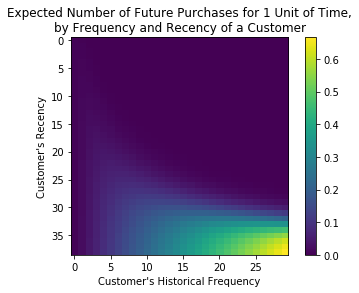

In [25]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

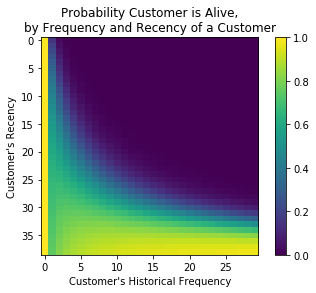

In [12]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

Another plotting function is the probability that the customer is alive. It reflects the first chart in the sense customers who bought very recently t=25 or more have a greater probabilty that they are alive.

Now we have the model estimates calculated by maximising the log liklihood of some complex equation we can calculate the conditional expected (average) transactions in the next period and rank the customers from best to worse.

This next function calculates the expected number of repeat purchases up to time t for a randomly choose individual from the population, given they have purchase history (frequency, recency, T)

In this example customer 1516 has purhcased in 26 periods, his latest transaction was in the 30th period and is total age is 31 periods. The model has predicted in the next period t=1 he is expected to have bought 0.71 units. Increasing t you get more units.

In [30]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424878
841,19,34.00,34.14,0.474739
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662397
1516,26,30.86,31.00,0.710624


So we've fitted our model to the rf data from CDNOW but is it anygood?
We can compared the real data to some simulations from the model. The package has a generate new data function embedded within the plot_period_transactions to simulate n number of customers where n is the same as the actual. The function combines the counts from actual and simulated then plots.

If they line up your model doesn't suck but...

*not explained this the best :(

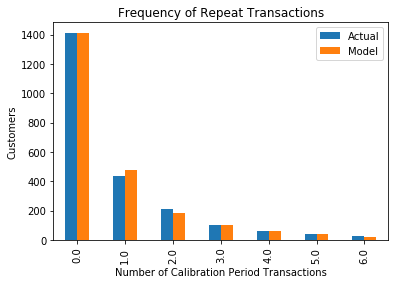

In [15]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

More often that not you will just have a list of transaction data perhaps a timestamp of the transaction date and then the customer id.
Lifetimes has some utilty functions to create R F and age variables before you pass into the fitters. In previous work I've done this manually in R using dplyr and by scaling into week periods and then counting within each group. The code in R was based on this blog but doesn't seem to be there anymore. Anyway it's something like this ...

https://github.com/rtheman/CLV/blob/master/2_Code/RFM_v0.2.R

In [12]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [13]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')
print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


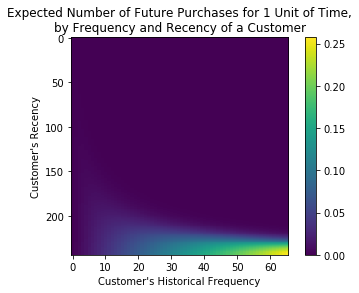

In [14]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

In this map again customers who bought most frequently and recently are bottom right. There is also this tail. I think this analysis would be really neat to see not just for transactions but web visits too.

With transactional data we normally want to split the data into a calibration period which we model on then test on a hold out period to see how well it performs.

In [4]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )   
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0               121
1             0.0          0.0  103.0                0.0               121
2             6.0        142.0  171.0                0.0               121
3             0.0          0.0   26.0                0.0               121
4             2.0          9.0   62.0                0.0               121


From this we can then test on the holdout columns. So we fit a bgf to calibration period then pass to a a plotter the model and thesummary cal holdot.

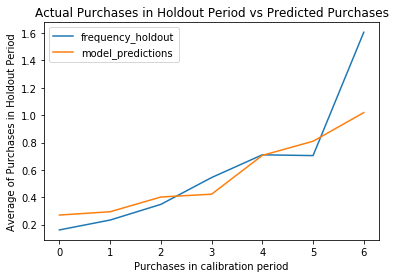

In [10]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

So in this case our model predicts 0.4 average purchases in the holdout period when the number of purhcases incalibration is 3. However this under performs the actual which is more like 0.5.

We can also predict for an indidual the number of purchases inthe next t periods using the bgf. For individual 20 in the next 10 periods we see the model preicts he'll make 0.06 purhcases over 10 days. Not our best customer.

In [21]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
# 0.0576511

0.057651126193892094

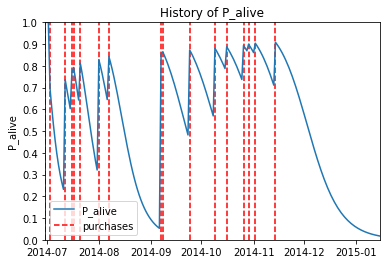

In [22]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

In [23]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

NameError: name 'summary_with_money_value' is not defined